In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

### SW installation instructions

To follow this notebook you have to be able to run Jupyter notebooks on your PC as well as have installed version 0.19 of scikit-learn and 2.1 of keras (or posterior; current versions are 2.2 for keras and 0.20 for scikit-learn).

The simplest way of doing so is to download and install the Miniconda distribution from 

    https://conda.io/miniconda.html 

and then use the command `conda install` to add the `ìpython, scikit-learn` and `keras` packages.

A convenient alternative for Windows is the WinPython distribution https://winpython.github.io/.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

from sklearn.datasets import load_boston

# Optimization on NNs

1. Batch vs minibatch: lbfgs vs adam in sklearn
2. Performance of keras optimizers
3. DNNs do not overfit: train vs validation in keras

## 1. Batch vs minibatch: lbfgs vs adam in sklearn

We will work with the housing dataset obtained from sklearn.

### Loading the data

Load and prepare the data

In [4]:
boston_data = load_boston()

df_housing = pd.DataFrame(data=boston_data['data'], columns=boston_data['feature_names'])
df_housing['MEDV'] = boston_data['target']

vars   = df_housing.columns[ : -1]
target = df_housing.columns[-1]

std_sc = StandardScaler()

x = std_sc.fit_transform( df_housing[ vars ].values )
y = df_housing[ target ].values

n_patterns, dim = x.shape

### First training using `lbfgs`

Define and fit the model

In [5]:
hidden_layer_sizes = (40, 20)
alpha_S = 100.
tol = y.std() * 1.e-6

mlp_s =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                      alpha=alpha_S,
                      activation='relu', 
                      solver='lbfgs', 
                      #batch_size=batch_size,
                      tol=tol, 
                      max_iter=10000,
                      early_stopping=False)

t0 = time.time()
mlp_s.fit(x, y)
t1 = time.time()

Let's print some training information

In [6]:
print("lbfgs_iters \t%d" % mlp_s.n_iter_)
print("lbfgs_loss  \t%.3f" % mlp_s.loss_)
print("train_time  \t%.4f" % (t1-t0))

y_pred = mlp_s.predict(x)
print("lbfgs_pred_loss: %.3f" % (mean_squared_error(y, y_pred)))

lbfgs_iters 	3651
lbfgs_loss  	5.938
train_time  	21.4592
lbfgs_pred_loss: 5.096


### Training using `adam`

Print some training info and draw the loss evolution

In [7]:
batch_size = n_patterns
batch_size = 200
tol = y.var() * 1.e-6

mlp_s =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                      alpha=alpha_S,
                      activation='relu', 
                      solver='adam', 
                      #nesterovs_momentum=False,
                      batch_size=batch_size,
                      tol=tol*1.e-3, 
                      max_iter=20000,
                      early_stopping=False)

t0 = time.time()
mlp_s.fit(x, y)
t1 = time.time()

In [8]:
print("adam_iters \t%d" % mlp_s.n_iter_)
print("adam_loss  \t%.3f" % mlp_s.loss_)
print("train_time \t%.4f" % (t1-t0))

y_pred = mlp_s.predict(x)
print("adam_pred_loss: %.3f" % (mean_squared_error(y, y_pred)))

adam_iters 	976
adam_loss  	11.320
train_time 	12.3640
adam_pred_loss: 11.246


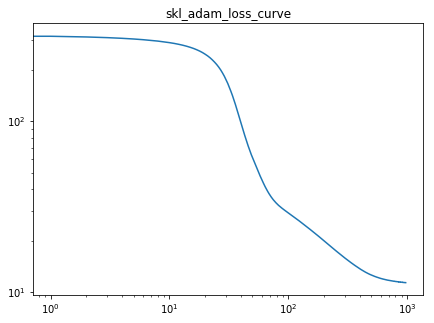

In [9]:
plt.figure( figsize=(7,5))
plt.title("skl_adam_loss_curve")
plt.xscale('log')
plt.yscale('log')
_ = plt.plot(mlp_s.loss_curve_)

## Performance of keras optimizers

We import the required moduli

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Nadam, Adamax
from keras.callbacks import EarlyStopping, History

import keras.backend as K

Using TensorFlow backend.


First define the network:

* We plug a layer's output as the input for the next one
* We use ReLU as hidden activations, and a linear outputs
* We adjust the `alpha` used with scikit-learn

In [11]:
alpha_K = alpha_S/n_patterns/2.

# input
main_input = Input(shape=(dim, ))

# layers
z = main_input

for num_hidden in hidden_layer_sizes:
    layer = Dense(num_hidden, kernel_initializer="he_uniform", 
                  activation='relu', 
                  kernel_regularizer=l2(alpha_K))
                  #kernel_regularizer=l2(alpha))
    z = layer(z)

# output    
ls_layer = Dense(units=1,
                 activation='linear', 
                 #kernel_initializer="glorot_uniform", 
                 kernel_initializer="he_uniform", 
                 kernel_regularizer=l2(alpha_K),
                 name='ls_output')
ls_output = ls_layer(z)

# compile
mlp_k = Model(inputs=[main_input], outputs=[ls_output])

print(mlp_k.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                560       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
ls_output (Dense)            (None, 1)                 21        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________
None


Then print and plot training information for different solvers:

* We re-initialize the weights after each training
* We define `callbacks` to monitor and stop training

In [12]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

tol = y.var() * 1.e-6            
callbacks = [History(), 
             EarlyStopping(monitor='loss',
                    min_delta=tol, 
                    patience=10)
            ]        
d_h = {}
for k, optimizer in enumerate([Adadelta(), Adagrad(), Adam(), Nadam()]):
    t0 = time.time()
    reset_weights(mlp_k)
    mlp_k.compile(optimizer=optimizer, loss={'ls_output': 'mean_squared_error'})
    mlp_k.fit(x, y, 
              epochs=10000,
              batch_size=batch_size,
              callbacks=callbacks,
              shuffle=True,
              verbose=0)
    t1 = time.time()    
    
    d_h[k] = mlp_k.history.history['loss']
    
    print("\n", optimizer)
    print("\titers \t%d" % len(mlp_k.history.history['loss']))
    print("\tloss  \t%.3f" % mlp_k.history.history['loss'][-1])
    print("\tpred_loss  \t%.3f" % mlp_k.evaluate(x, y, verbose=0))
    print("\ttrain_time \t%.4f" % (t1-t0))

Instructions for updating:
Use tf.cast instead.

	iters 	488
	loss  	12.021
	pred_loss  	11.961
	train_time 	10.9350

	iters 	6019
	loss  	11.960
	pred_loss  	11.954
	train_time 	49.5628

	iters 	1815
	loss  	9.566
	pred_loss  	9.530
	train_time 	18.2772

	iters 	889
	loss  	10.160
	pred_loss  	9.998
	train_time 	11.6658


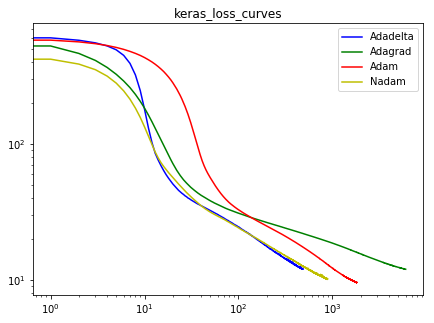

In [13]:
plt.figure( figsize=(7,5))
plt.title("keras_loss_curves")

l_colors = ['b', 'g', 'r', 'y']
l_labels = ['Adadelta', 'Adagrad', 'Adam', 'Nadam']

for k, c, l in zip( d_h.keys(), l_colors, l_labels):
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(d_h[k], color=c, label=l)

plt.legend(loc='best')
plt.show()

## Do DNNs overfit? Train vs validation in keras

We use again callbacks to compute and store the paralel evolution of the train and validation losses which we plot at the end

In [14]:
idx = np.array(range(n_patterns))

np.random.shuffle(idx) 

idx_1 = idx[ : n_patterns//2]
idx_2 = idx[n_patterns//2 : ]
x_1 = x[idx_1, : ]
y_1 = y[idx_1]

x_2 = x[idx_2, : ]
y_2 = y[idx_2]

reset_weights(mlp_k)
mlp_k.compile(optimizer=Adam(), loss={'ls_output': 'mean_squared_error'})
mlp_k.fit(x_1, y_1, 
              epochs=10000,
              #batch_size=batch_size,
              batch_size=50,
              callbacks=callbacks,
              shuffle=True,
              validation_data=[x_2, y_2], 
              verbose=0)

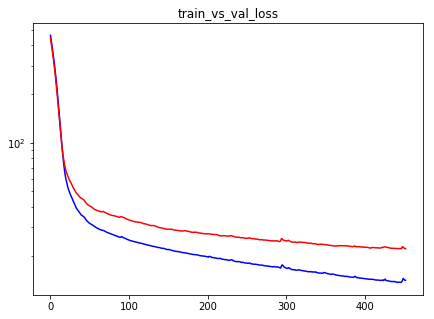

In [15]:
plt.figure( figsize=(7,5))
plt.title("train_vs_val_loss")

#plt.xscale('log')
plt.yscale('log')

_ = plt.plot(mlp_k.history.history['loss'], 'b', mlp_k.history.history['val_loss'], 'r')